In [2]:
"""
Name: Module 4 RFM Analysis.py
Course: Data Preparation and Analysis
"""

'\nName: Module 4 RFM Analysis.py\nCourse: Data Preparation and Analysis\n'

In [2]:
import matplotlib.pyplot as plt
import numpy
import pandas
import random
import sys

import seaborn
from datetime import datetime

In [3]:
# Set some options for printing all the columns
numpy.set_printoptions(precision = 10, threshold = sys.maxsize)
numpy.set_printoptions(linewidth = numpy.inf)
pandas.set_option('display.max_columns', None)
pandas.set_option('display.expand_frame_repr', False)
pandas.set_option('max_colwidth', None)
pandas.options.display.float_format = '{:,.10f}'.format

In [4]:
transaction = pandas.read_csv('Data/rfm_Transactions.csv')
transaction.head()

,CustomerID,ProductLine,ProductNumber,Date,Amount
0,300,B-200,228,1/1/2021,40
1,347,A-100,171,1/1/2021,36
2,373,E-500,571,1/1/2021,169
3,489,E-500,592,1/1/2021,182
4,507,D-400,438,1/1/2021,142


In [5]:
transaction.describe()

,CustomerID,ProductNumber,Amount
count,"4,906.0000000000","4,906.0000000000","4,906.0000000000"
mean,497.2492865879,346.6090501427,94.6102731349
std,286.1968791649,145.9874641387,57.8270098372
min,1.0000000000,101.0000000000,10.0000000000
25%,250.2500000000,220.0000000000,45.0000000000
50%,498.0000000000,345.0000000000,81.0000000000
75%,746.7500000000,472.0000000000,137.0000000000
max,"1,000.0000000000",598.0000000000,219.0000000000


In [6]:
# Calculate Number of days since 12/31/2020
t_date = pandas.to_datetime(transaction['Date'], format='%m/%d/%Y')
reference_date = datetime.strptime('12/31/2020', "%m/%d/%Y")
n_days = pandas.Series((t_date - reference_date) / numpy.timedelta64(1, 'D'), name = 'N Days')
print(n_days)

0        1.0000000000
1        1.0000000000
2        1.0000000000
3        1.0000000000
4        1.0000000000
            ...      
4901   365.0000000000
4902   365.0000000000
4903   365.0000000000
4904   365.0000000000
4905   365.0000000000
Name: N Days, Length: 4906, dtype: float64


In [7]:
# Create the training data
train_data = transaction[['CustomerID', 'Date', 'Amount']].join(n_days)
train_data.describe()

,CustomerID,Amount,N Days
count,"4,906.0000000000","4,906.0000000000","4,906.0000000000"
mean,497.2492865879,94.6102731349,183.4052181003
std,286.1968791649,57.8270098372,87.6578121671
min,1.0000000000,10.0000000000,1.0000000000
25%,250.2500000000,45.0000000000,118.0000000000
50%,498.0000000000,81.0000000000,184.0000000000
75%,746.7500000000,137.0000000000,248.0000000000
max,"1,000.0000000000",219.0000000000,365.0000000000


In [8]:
train_data.head()

,CustomerID,Date,Amount,N Days
0,300,1/1/2021,40,1.0000000000
1,347,1/1/2021,36,1.0000000000
2,373,1/1/2021,169,1.0000000000
3,489,1/1/2021,182,1.0000000000
4,507,1/1/2021,142,1.0000000000


In [9]:
# Define the aggregation procedure outside of the groupby operation
aggregations = {
    'N Days':'max',
    'CustomerID': 'count',
    'Amount': 'sum'
}

column_map = {'N Days': 'Recency', 'CustomerID': 'Frequency', 'Amount': 'Monetary'}

customer_data = train_data.groupby('CustomerID').agg(aggregations).rename(columns = column_map)
rfm_names = customer_data.columns
customer_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
1,298.0000000000,5,485
2,337.0000000000,4,350
3,155.0000000000,2,233
4,280.0000000000,7,936
5,188.0000000000,3,359


In [10]:
# Determine the quintiles
quintile = customer_data.describe(percentiles = [0.2, 0.4, 0.6, 0.8])

In [11]:
# Assign customers to groups
customer_group = pandas.DataFrame(numpy.where(numpy.isnan(customer_data),0,1), index = customer_data.index)

for q in ['20%','40%','60%','80%']:
   customer_group = customer_group + numpy.where(customer_data[rfm_names] > quintile.loc[q][rfm_names], 1, 0)

customer_group = customer_group.rename(columns = {0: 'Recency Score', 1: 'Frequency Score', 2: 'Monetary Score'})
print(customer_group)

            Recency Score  Frequency Score  Monetary Score
CustomerID                                                
1                       3                3               3
2                       5                2               2
3                       1                1               1
4                       3                4               5
5                       1                1               2
...                   ...              ...             ...
996                     1                1               1
997                     1                1               1
998                     3                1               1
999                     1                1               1
1000                    1                1               1

[995 rows x 3 columns]


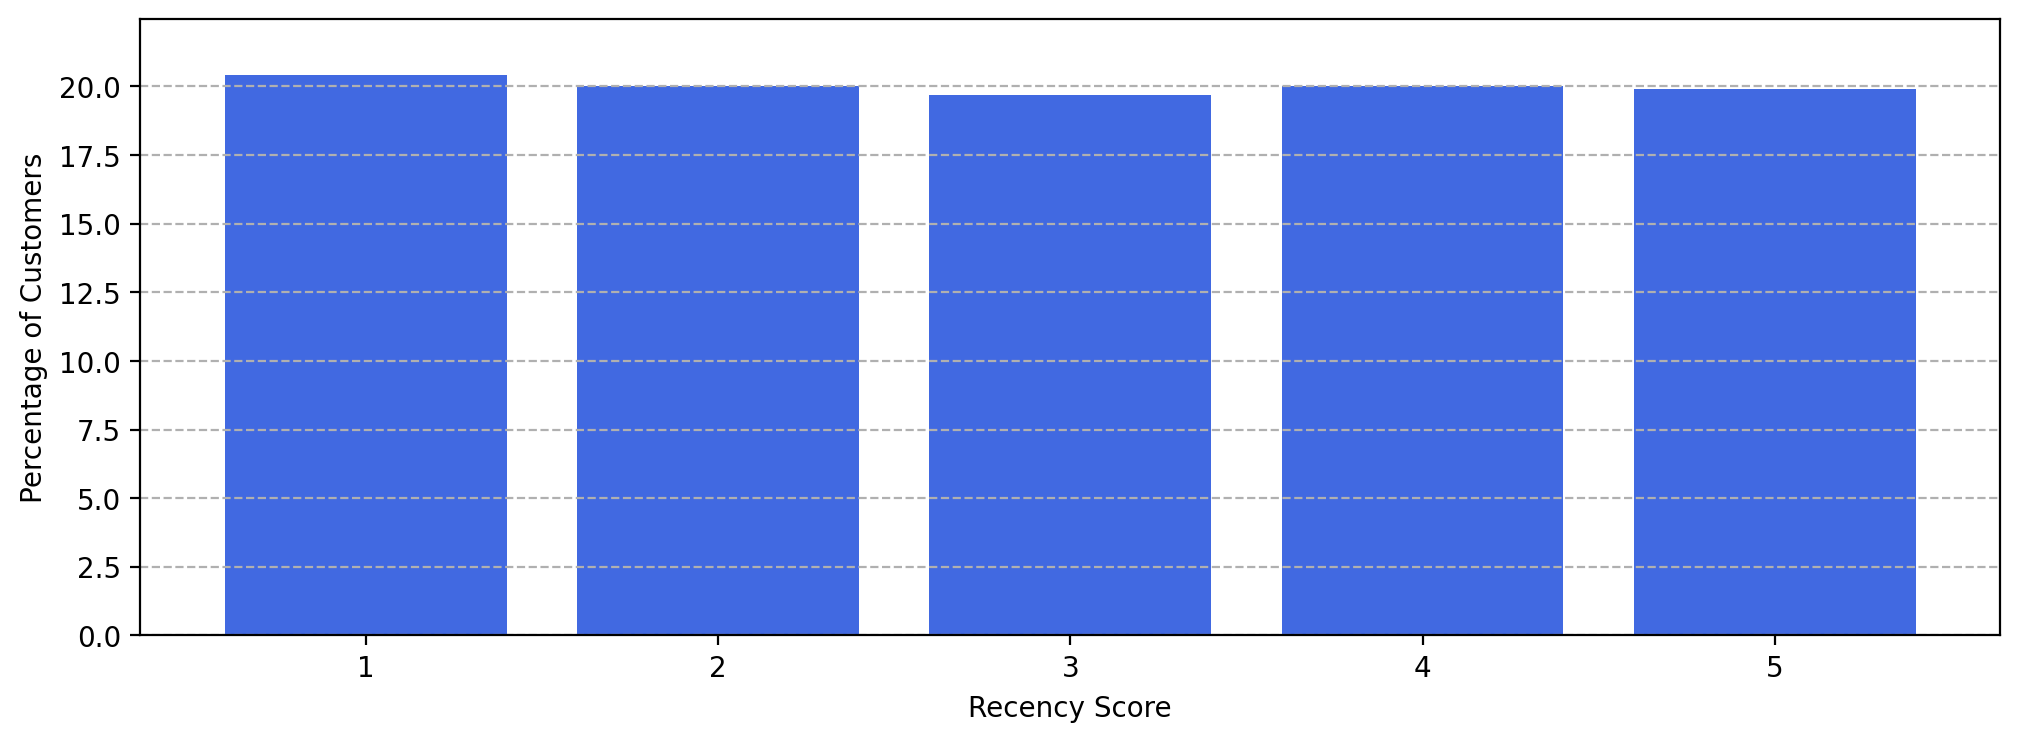

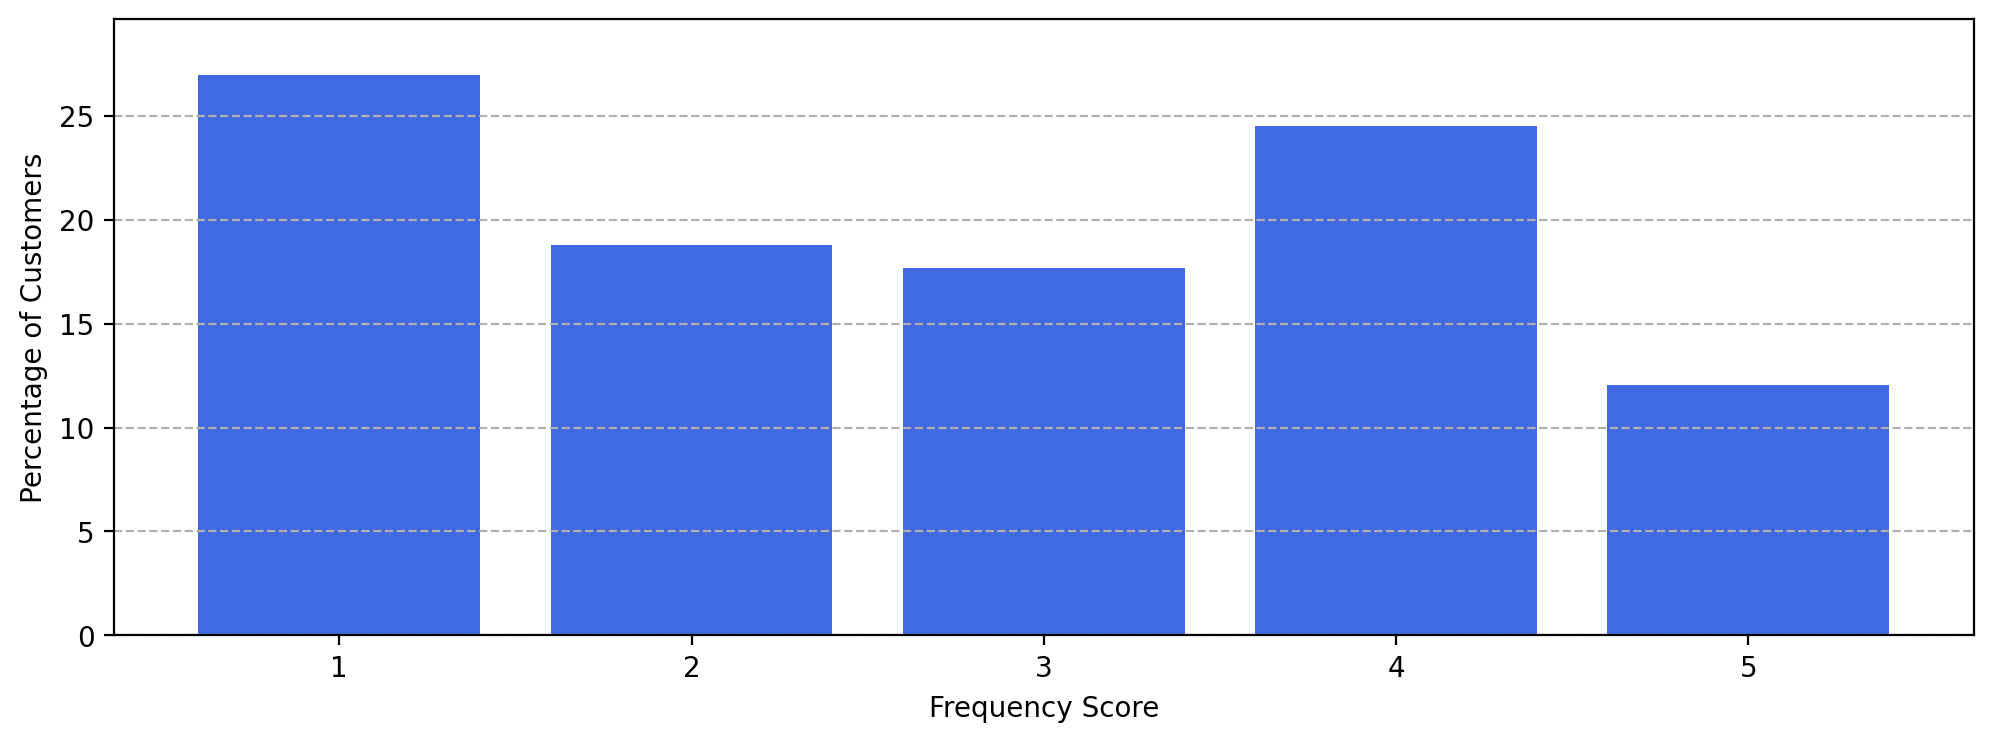

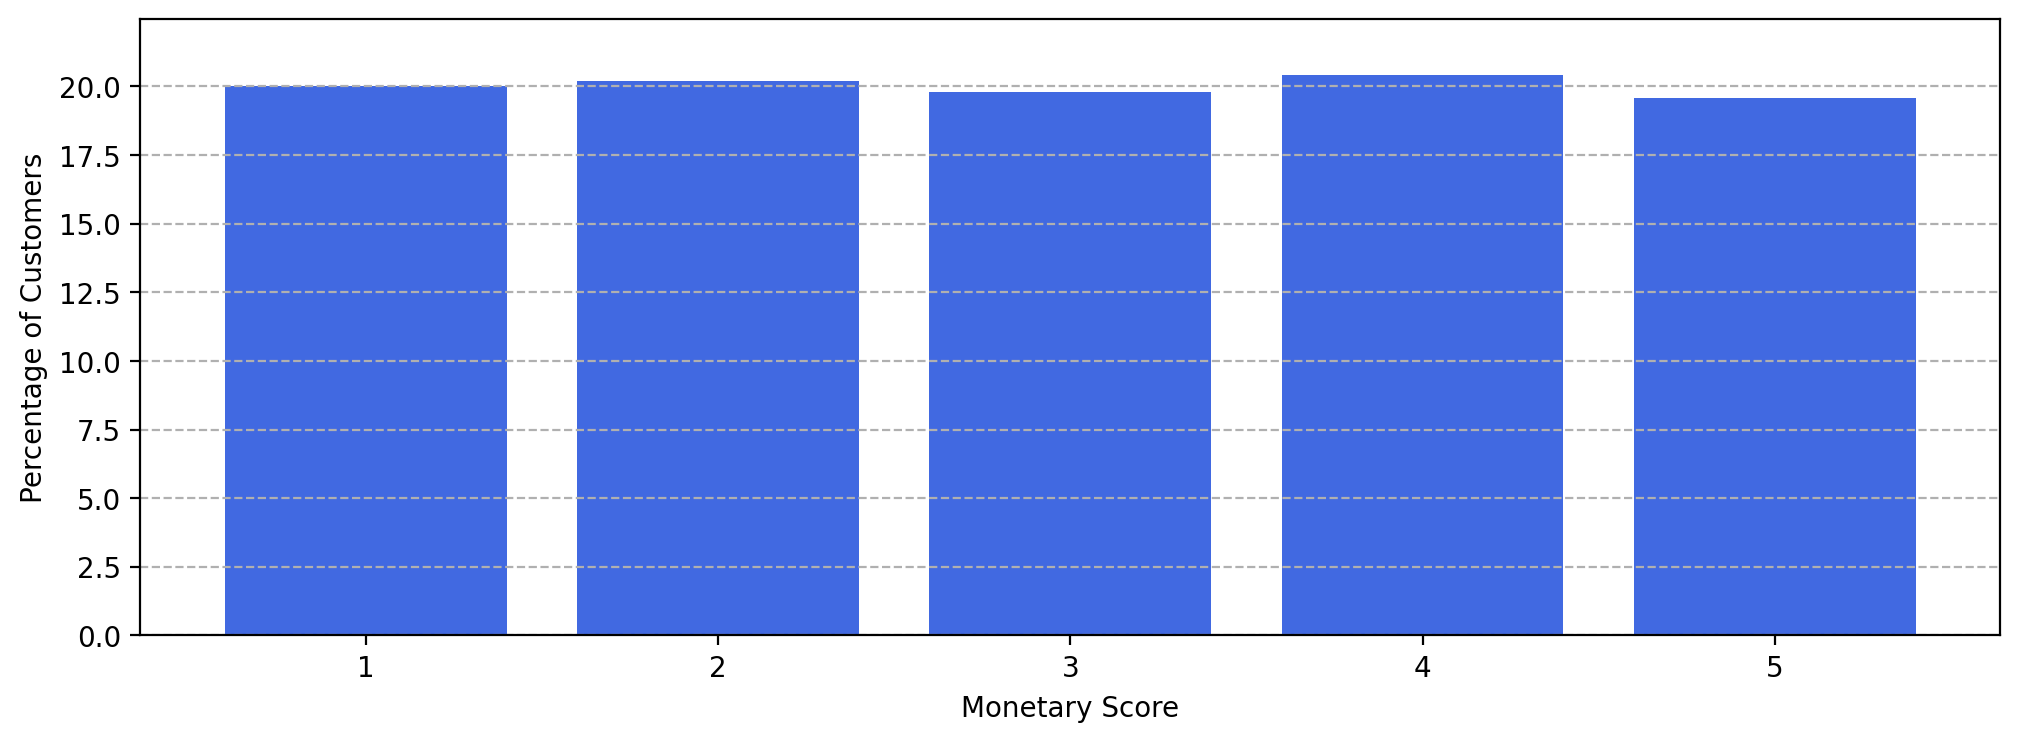

In [12]:
# Inspect bar charts of each group
for g in ['Recency Score', 'Frequency Score','Monetary Score']:
   group_prop = 100 * customer_group[g].value_counts(ascending = True, normalize = True)

   plt.figure(figsize = (12,4), dpi = 200)
   plt.bar(group_prop.index, group_prop, color = 'royalblue')
   plt.xlabel(g)
   plt.ylabel('Percentage of Customers')
   plt.xticks(range(1,6,1))
   plt.grid(axis = 'y', linestyle = '--')
   plt.margins(y = 0.1)
   plt.show()

In [13]:
# Merge the group assignments back to the customer data
customer_data = customer_data.join(customer_group)

customer_data['RFM Score'] = 100 * customer_data['Recency Score'] + 10 * customer_data['Frequency Score'] + customer_data['Monetary Score']

print(customer_data)

                  Recency  Frequency  Monetary  Recency Score  Frequency Score  Monetary Score  RFM Score
CustomerID                                                                                               
1          298.0000000000          5       485              3                3               3        333
2          337.0000000000          4       350              5                2               2        522
3          155.0000000000          2       233              1                1               1        111
4          280.0000000000          7       936              3                4               5        345
5          188.0000000000          3       359              1                1               2        112
...                   ...        ...       ...            ...              ...             ...        ...
996        179.0000000000          1        23              1                1               1        111
997        113.0000000000          3       195

In [14]:
top_rfm_scores = customer_data.sort_values(by='RFM Score', ascending=False).head(10)
print(top_rfm_scores)

                  Recency  Frequency  Monetary  Recency Score  Frequency Score  Monetary Score  RFM Score
CustomerID                                                                                               
950        362.0000000000          8       775              5                5               5        555
420        338.0000000000          9      1003              5                5               5        555
409        357.0000000000          9       805              5                5               5        555
547        348.0000000000         11       713              5                5               5        555
47         365.0000000000          9       927              5                5               5        555
549        359.0000000000         12      1150              5                5               5        555
49         352.0000000000          8       839              5                5               5        555
142        362.0000000000         10       900

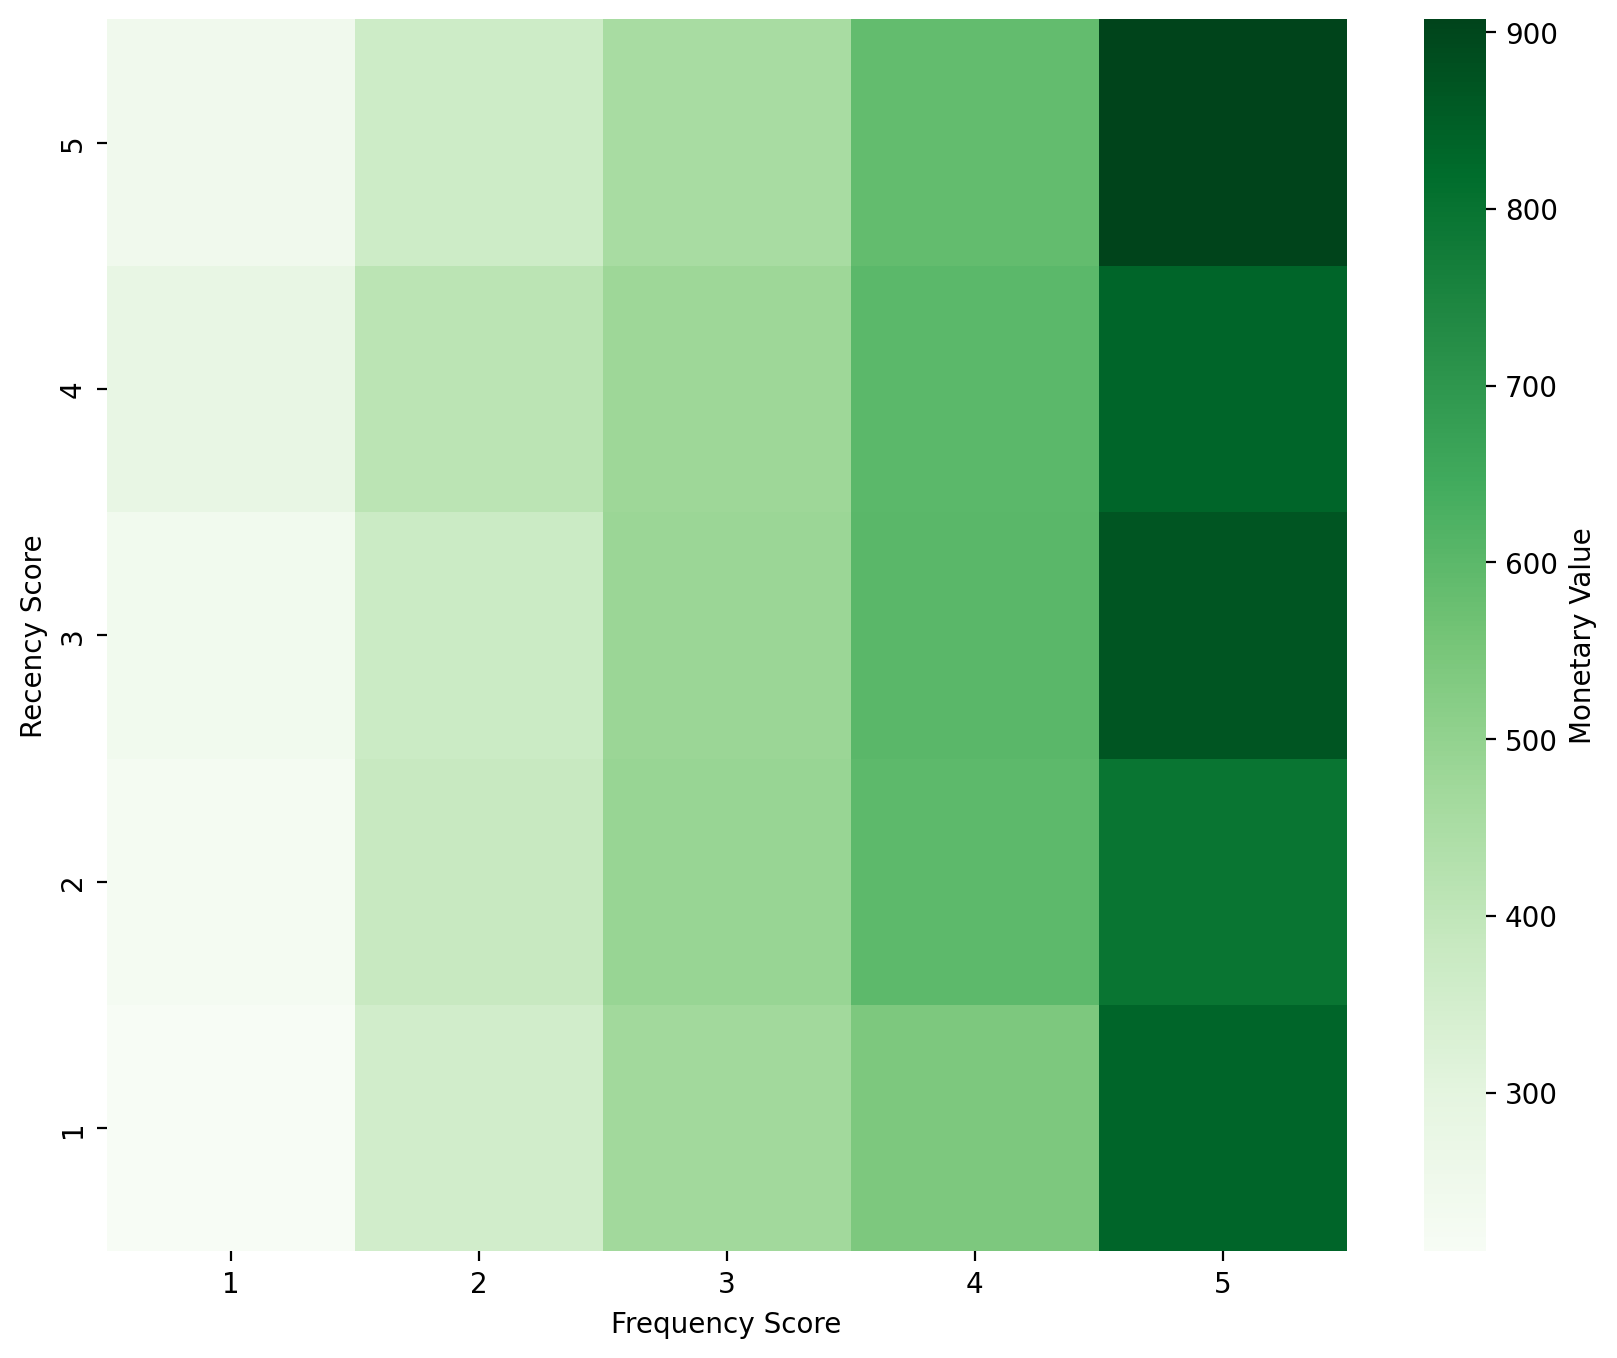

In [15]:
# Look at Monetary value by Recency and Frequency groups
xtab = pandas.crosstab(index = customer_data['Recency Score'], columns = customer_data['Frequency Score'],
                       values = customer_data['Monetary'], aggfunc = 'mean')
plt.figure(figsize = (10,8), dpi = 200)
seaborn.heatmap(xtab, cmap = 'Greens', cbar_kws={'label': 'Monetary Value'})
plt.gca().invert_yaxis()
plt.show()

In [16]:
# Copy the RFM Score back to the transaction data
transaction_rfm = transaction.merge(customer_data['RFM Score'], left_on = ['CustomerID'], right_on = customer_data.index)
print(transaction_rfm)

      CustomerID ProductLine  ProductNumber        Date  Amount  RFM Score
0            300       B-200            228    1/1/2021      40        243
1            347       A-100            171    1/1/2021      36        334
2            373       E-500            571    1/1/2021     169        355
3            489       E-500            592    1/1/2021     182        445
4            507       D-400            438    1/1/2021     142        233
...          ...         ...            ...         ...     ...        ...
4901         365       C-300            340  12/31/2021     115        544
4902         387       E-500            506  12/31/2021     215        555
4903         595       E-500            582  12/31/2021     178        511
4904         683       A-100            120  12/31/2021      21        545
4905         961       C-300            387  12/31/2021     114        511

[4906 rows x 6 columns]


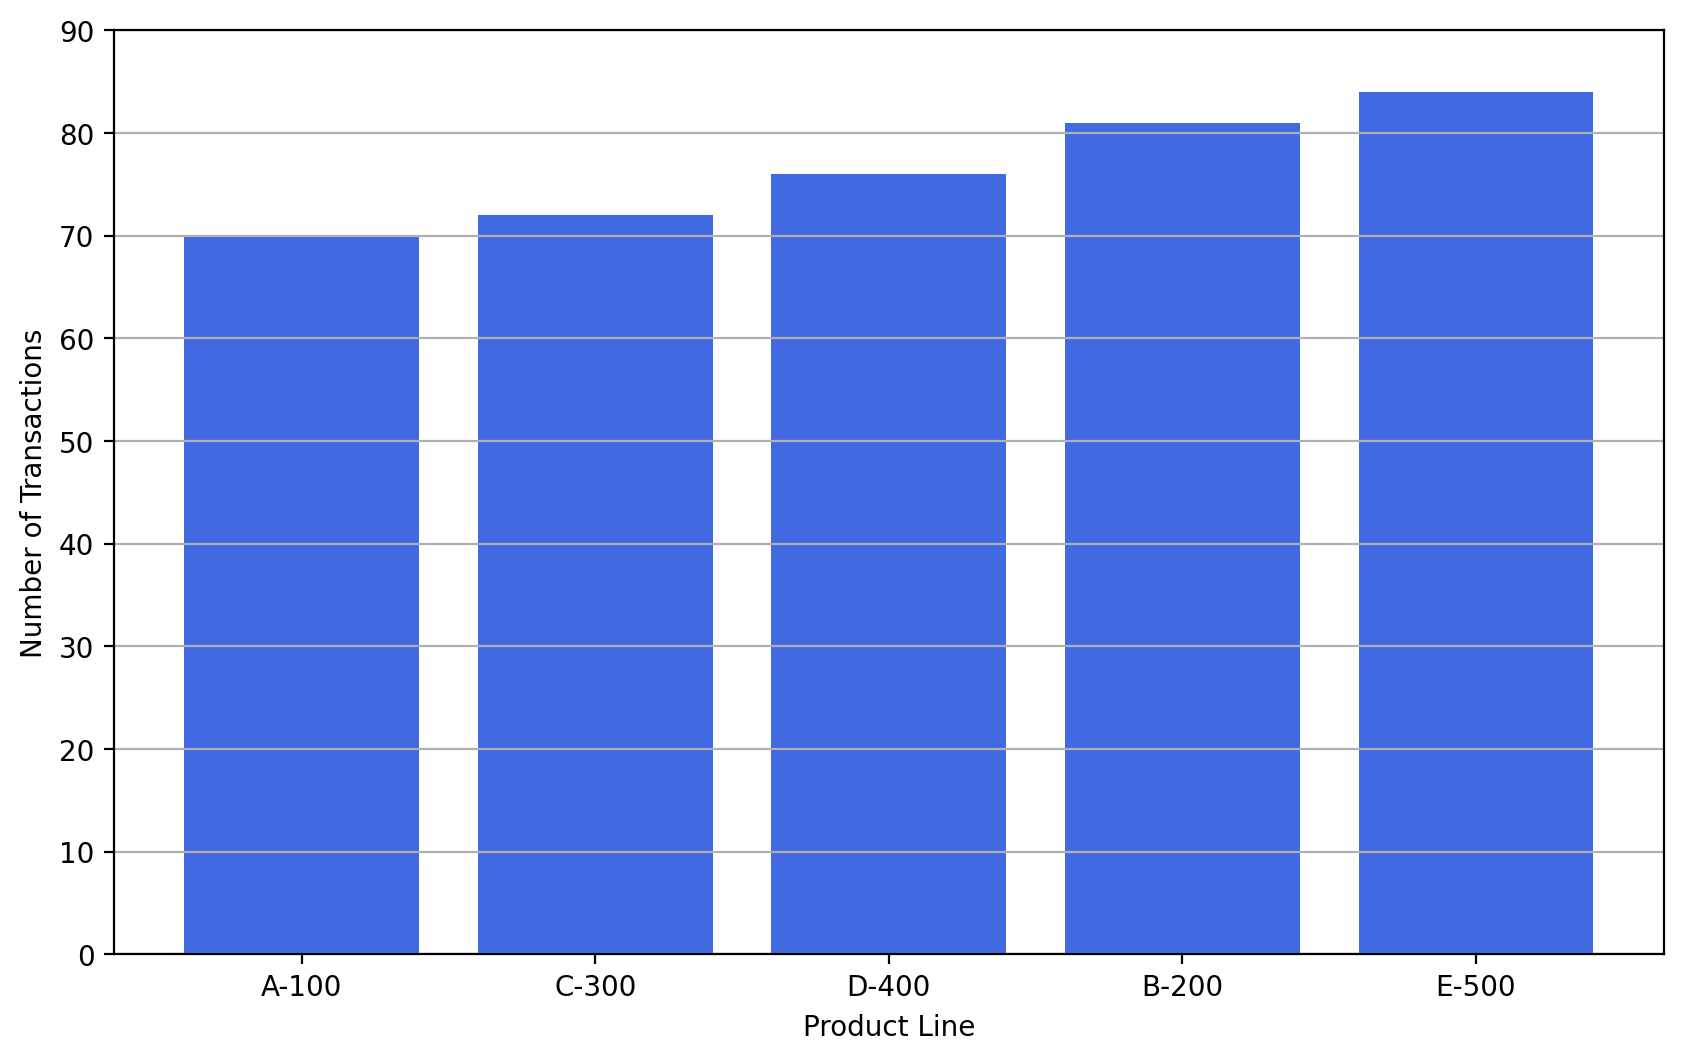

In [17]:
# What kind of products do the customers with RFM score 555 buy?
focus_data = transaction_rfm[transaction_rfm['RFM Score'] == 555]

product_size = focus_data['ProductLine'].value_counts(ascending = True)

plt.figure(figsize = (10,6), dpi = 200)
plt.bar(product_size.index, product_size, color = 'royalblue')
plt.yticks(range(0,100,10))
plt.xlabel('Product Line')
plt.ylabel('Number of Transactions')
plt.grid(axis = 'y')
plt.show()